In [1]:
from attridict import AttriDict

TRIGGERS = AttriDict(
    STATEEND=10,
    TRIALEND=11,
    BLOCKEND=12,
    ITI=13,
    FIXATION=14,
    BREAK=15,
    INTERBLOCK=16,
    ABORT=17,
    ERROR=18,
    EXPEND=255,
    # 20-30 are reserved for the query condition
    QUERY=dict(
        TRUE=dict(
            F1LEFT=20,
            F1RIGHT=21,
        ),
        FALSE=dict(
            F1LEFT=22,
            F1RIGHT=23,
        ),
    ),
    # 30-40 are reserved for the two-word stimulus condition
    TWOWORD=dict(
        PHRASE=dict(
            F1LEFT=30,
            F1RIGHT=31,
        ),
        NONPHRASE=dict(
            F1LEFT=32,
            F1RIGHT=33,
        ),
        NONWORD=dict(
            F1LEFT=34,
            F1RIGHT=35,
        ),
    ),
    # 40-50 are reserved for the one-word stimulus condition
    ONEWORD=dict(
        WORD=dict(
            F1=40,
            F2=41,
        ),
        NONWORD=dict(
            F1=42,
            F2=43,
        ),
    ),
)

In [2]:
import mne
import pandas as pd
import numpy as np
from autoreject import AutoReject
from pathlib import Path
from scipy.interpolate import interp1d
from intermodulation.utils import nested_iteritems

mne.set_config("MNE_BROWSER_BACKEND", "matplotlib")
%matplotlib inline

# Load the epoched data
datapath = Path("/home/gercek/scratch/syntax_im/241018/")
rawfile = datapath / "pilot03_cHPI_line_sss.fif"
events = mne.read_events(datapath / "pilot03-eve.fif")
annot = mne.read_annotations(datapath / "pilot03-badseg-annot.fif")
raw = mne.io.read_raw_fif(rawfile, preload=True)
raw.set_annotations(annot)

Using matplotlib as 2D backend.
Opening raw data file /home/gercek/scratch/syntax_im/241018/pilot03_cHPI_line_sss.fif...


/tmp/ipykernel_4041268/3895709904.py:17: RuntimeWarning: This filename (/home/gercek/scratch/syntax_im/241018/pilot03_cHPI_line_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(rawfile, preload=True)


    Range : 19000 ... 1751999 =     19.000 ...  1751.999 secs
Ready.
Opening raw data file /home/gercek/scratch/syntax_im/241018/pilot03_cHPI_line_sss-1.fif...
    Range : 1752000 ... 2674999 =   1752.000 ...  2674.999 secs
Ready.
Reading 0 ... 2655999  =      0.000 ...  2655.999 secs...


<Raw | pilot03_cHPI_line_sss.fif, 326 x 2656000 (2656.0 s), ~6.46 GB, data loaded>

Now that we have discrete epochs, we can look at the raw data to get an idea of artifacts present. We'll first look for low-frequency drifts, which don't appear to be present in the data:

Setting up low-pass filter at 2.4e+02 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 240.00 Hz: -6.02 dB



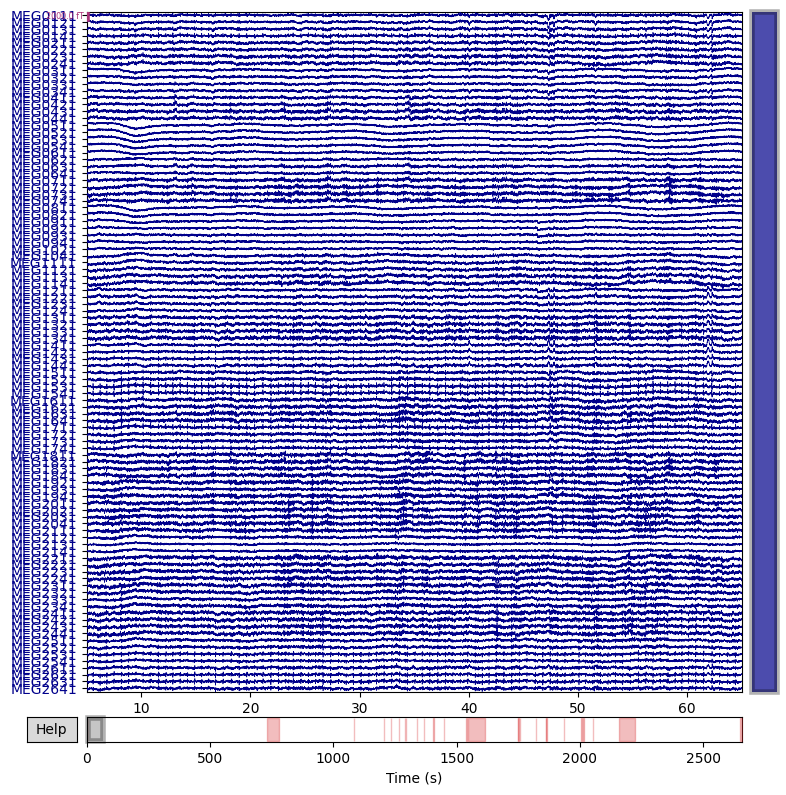

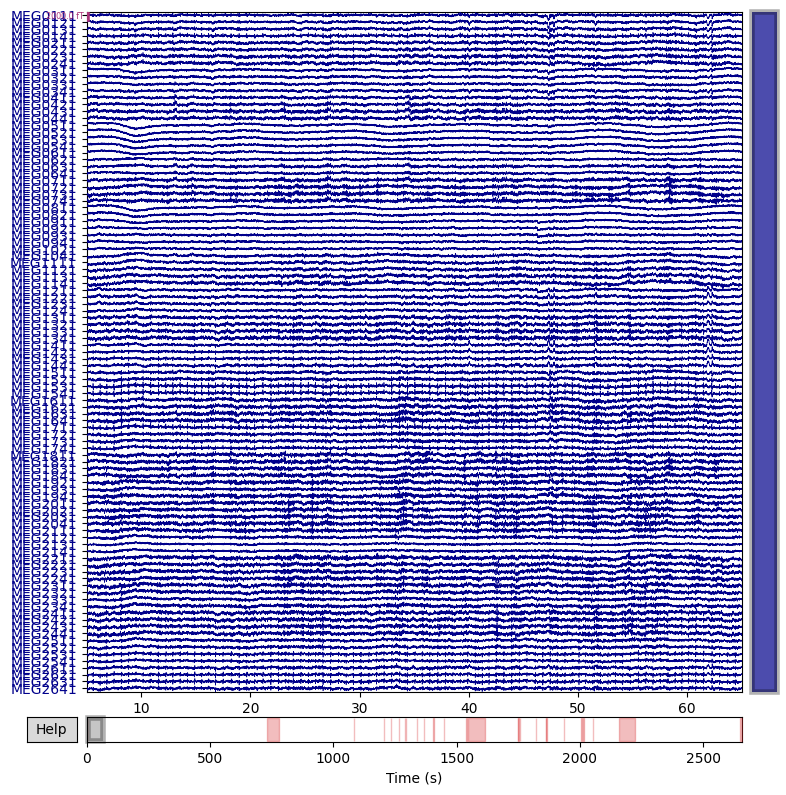

In [3]:
mag_channels = mne.pick_types(raw.info, meg="mag")
raw.plot(
    start=5.0,
    duration=60.0,
    order=mag_channels,
    n_channels=len(mag_channels),
    remove_dc=False,
    use_opengl=True,
    lowpass=240.0,
)

Let's also look at the ICA projections for the first few components while we're at it, for the filtered data. These look good to my naive eye, and don't show any substantial problems:

In [6]:
ica = mne.preprocessing.ICA(n_components=100, random_state=97, max_iter=800)
rawfil = raw.copy().filter(1, 40, n_jobs=-1)
ica.fit(rawfil, reject=None, reject_by_annotation=True)

Filtering raw data in 6 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:    2.5s finished


Fitting ICA to data using 297 channels (please be patient, this may take a while)
Omitting 213299 of 2656000 (8.03%) samples, retaining 2442701 (91.97%) samples.
Selecting by number: 100 components


/tmp/ipykernel_4041268/3399712827.py:3: RuntimeWarning: Using n_components=100 (resulting in n_components_=100) may lead to an unstable mixing matrix estimation because the ratio between the largest (52) and smallest (2.6e-16) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 76
  ica.fit(rawfil, reject=None, reject_by_annotation=True)


Fitting ICA took 782.5s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,126 iterations on raw data (2442701 samples)
ICA components,100
Available PCA components,297
Channel types,"mag, grad"
ICA components marked for exclusion,—


Now let's examine the 1w and 2w task epochs:

In [17]:
import matplotlib.pyplot as plt

plotdir = datapath / "ica_plots"
plotdir.mkdir(exist_ok=True)
for picks in [range(20), range(20, 40), range(40, 60), range(60, 80), range(80, 100)]:
    figs = ica.plot_properties(rawfil, picks=picks, figsize=(5, 6), show=False)
    for i, fig in enumerate(figs):
        fig.savefig(plotdir / f"ica_comp{picks[i]}.png")
        plt.close(fig)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
789 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
789 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
789 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
789 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
789 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
789 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
789 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
789 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
789 matching events found
No baseline correction applied
0 pro

Creating RawArray with float64 data, n_channels=100, n_times=2656000
    Range : 19000 ... 2674999 =     19.000 ...  2674.999 secs
Ready.


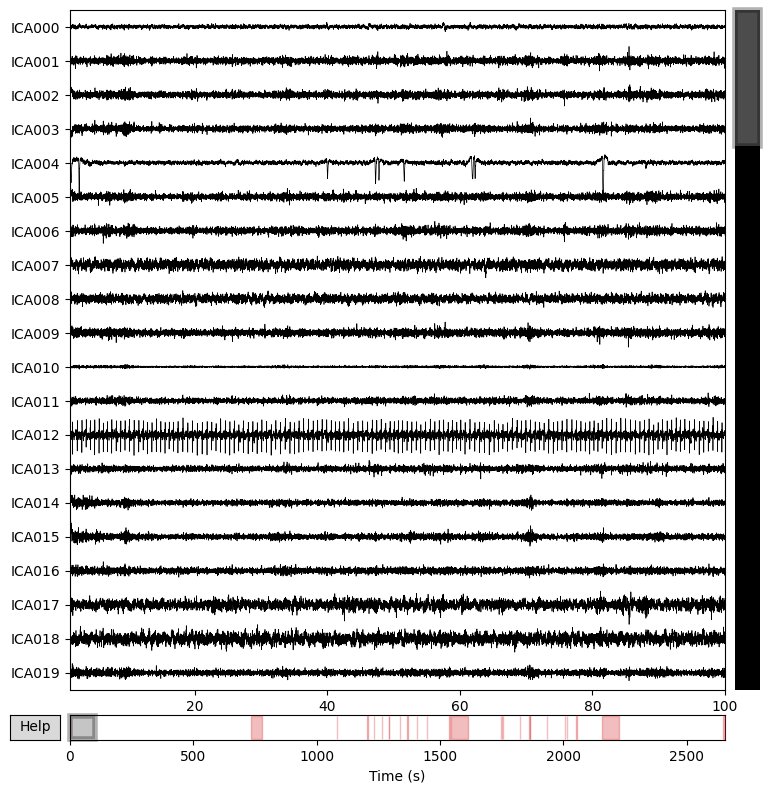

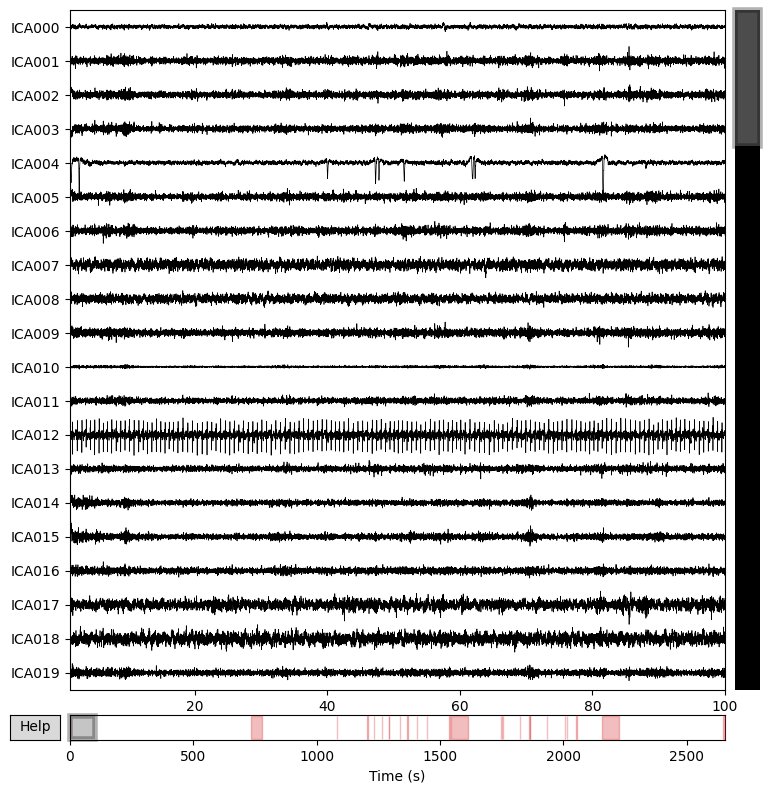

In [12]:
ica.plot_sources(rawfil, start=1.2, stop=100.0)

In [14]:
ica.apply(raw, exclude=[4, 12, 18])
ica.save(rawfile.with_name(rawfile.stem + "-ica.fif"))

Applying ICA to Raw instance


    Transforming to ICA space (100 components)
    Zeroing out 3 ICA components
    Projecting back using 297 PCA components
Writing ICA solution to /home/gercek/scratch/syntax_im/241018/pilot03_cHPI_line_sss-ica.fif...


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,126 iterations on raw data (2442701 samples)
ICA components,100
Available PCA components,297
Channel types,"mag, grad"
ICA components marked for exclusion,—


Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 2201 original time points ...
1 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Averaging across epochs before plotting...
Averaging across epochs before plotting...


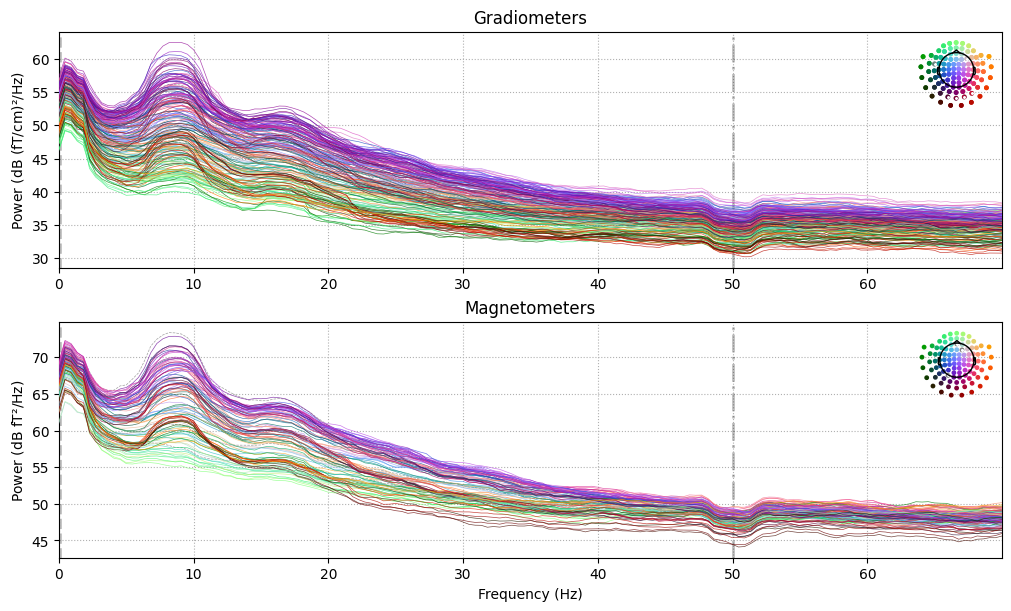

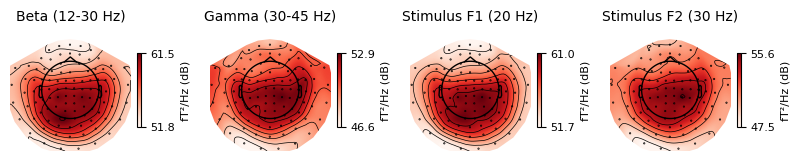

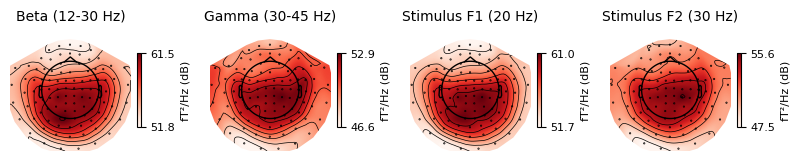

In [16]:
basebands = {"Beta (12-30 Hz)": (12, 30), "Gamma (30-45 Hz)": (30, 45)}
basebands["Stimulus F1 (20 Hz)"] = (19, 21)
basebands["Stimulus F2 (30 Hz)"] = (29, 31)

ev1w = events[np.isin(events[:, 2], np.arange(40, 51))]
usedtrigs = np.unique(ev1w[:, 2])
triglabels = {"/".join(k): v for k, v in nested_iteritems(TRIGGERS) if v in usedtrigs}
epochs1w = mne.Epochs(
    raw, ev1w, event_id=triglabels, tmin=-0.2, tmax=2.0, baseline=(None, 0), preload=True
)
spect1w = epochs1w["F1"].compute_psd(fmax=70, n_jobs=-1)
spect1w.plot(picks="data")
spect1w.plot_topomap(basebands, ch_type="mag", dB=True)